# Environment Agency Real Time flood-monitoring

## Management summary for this file

### Purpose: Time series analysis and prediction
This notebook uses Environment Agency data for a single monitoring station previously selected using the map in an associated tool EA_Flood.ipynb

Data is readily available for the past 12 months for all 6279 measuring instruments at 5391 monitoring stations across England. All this data has been persisted to a local PostgreSQL database to reduce internet traffic whilst developing this project. The csv file containing data for one instrument used this assignment has been extracted from that local database.  

Measurments from the Agency's flood-monitoring instruments are most commonly taken every 15 minutes but where changes are rapid, or where they critcal to the flood monitoring programme, measurements may be taken more frequently.  The station we are investigating here sits on the south bank of the River Severn in Gloucestershire, a river famous for having the second biggest tidal range in the world, at peak around 15 metres. This station collects data every 5 minutes and so for the year from March 2024 we have some 92,000 data points (from 170 million data points dowloaded for all stations in England). A rich dataset to work with.

### Support: API docs
Full API documentation can be found at "http://environment.data.gov.uk/flood-monitoring/doc/reference"
***

## Preparation

### Set programme directives

In [5]:
# Program directives

# Load data from local database or csv file (for small offshoot projects)
LOAD_FROM_CSV = True
TRAIN_MODEL = True   # can be time consuming. comment out if you're working on say presenation
MODEL_USING_SMOOTHED = False

### Install libraries 
(Set "INSTALL=True" to switch on once only, otherwise set "INSTALL=False")

In [7]:
INSTALL=False
if INSTALL:
    !pip install requests
    !pip install sqlalchemy
    !pip install gdal
    !pip install selenium pillow

### Import libraries

In [9]:
# Import libraries

# the key players
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# other general purpose libraries
import csv
from datetime import datetime
from datetime import timedelta

# for database connectivity
from sqlalchemy import create_engine
from sqlalchemy import text

# for interactive Bokeh plots
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, Button, CustomJS, DateRangeSlider, DatetimeTickFormatter, HoverTool, Range1d
from bokeh.models import WheelZoomTool, BoxZoomTool, PanTool, Label
from bokeh.layouts import column, row
from bokeh.io import output_notebook
from bokeh.io.export import export_png
#from bokeh.io.export import export_pdf

# for machine learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split


### Set display options

In [11]:
# to display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
# to set display width (for auto text wrapping)
pd.set_option('display.width', 180)
pd.set_option('max_colwidth', None)

# set float number format to 2dp
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.precision', 2)

# force dataframes to not wrap across lines
pd.set_option('display.expand_frame_repr', False)

## Working with the database

### Connection details for Postgresql

In [14]:
# Create an SQLAlchemy engine (aka a connection to the postgresql database) - this is required for pandas connections
if not LOAD_FROM_CSV:
    db_username = 'postgres'
    db_password = 'postgres'
    db_hostname = '192.168.101.12'
    db_port     = '5432'
    db_schema   = 'envagency'
    
    engine = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_hostname}:{db_port}/{db_schema}')

---

### Getting the data

In [17]:
# Define the start and end datetime for the range
start_datetime = '2024-04-02 00:00:00'
end_datetime   = '2025-03-31 00:00:00'

# The "station reference" identifier for the Environment Agency measuring instrument (eg water level gauge) 
stationReference = '2195'

if LOAD_FROM_CSV:
    df = pd.read_csv('EA_limited_dataset.csv')
    print('Loaded from csv')
else:
    query = f'''
            select * from readings where stationReference = '{stationReference}'
            and r_datetime between '{start_datetime}' AND '{end_datetime}'
            ''' 
    df = pd.read_sql_query(query, engine)
    print('Loaded from database')
    
    # If we are collecting this data from the datebase, lets save it to csv for 
    # portability to be used where access to this local database is restricted ro unavailable.
    df.to_csv('EA_limited_dataset.csv', index=False)  # index=False prevents writing row indices

# inspect the DataFrame
#print(df)


# Ensure the timeseries date column is correct for pandas
df['r_datetime'] = pd.to_datetime(df['r_datetime'])

# Sort the dataset by time
df = df.sort_values('r_datetime')

# Create a new column for a rolling average to smooth the 'value' column
# Our data points are every 5 minutes, so window=24 invokes 2 hour smoothing
df['value_smooth'] = df['value'].rolling(window=24, center=True).mean()


Loaded from csv


# Exploratory Data Analysis (EDA)

## Creating an interactive time series plot

In [20]:
#output_notebook()

def createTimeplot  (df, 
                     show_predicted = False,
                     future_predictions = None,
                     future_steps   = 48,
                     publishPlot    = False, 
                     plotName       ="SharpnessWaterLevelPlot.html"
                    ):
    '''
    Purpose:  Create an interactive timeseries chart, showing raw, smoothed, cleaned continuous data, and also identifying spikes and flatlining in the dataset
    Params:   The timeseries dataframe comprising a date/time column and a single value
    Returns:  A Bokeh plot object
    ''' 
    if df.empty:
        raise ValueError("DataFrame is empty. Cannot generate plot.")
    
    # column check
    required_columns = {'r_datetime', 'value'}
    missing = required_columns - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame is missing required column(s): {missing}")
    
    # =======================
    # An independent inquiry into cleaning data: 
    # =======================
    # Create column 'diff' - the absolute difference between this reading and the previous reading
    df['diff'] = df['value'].diff().abs()
    # Calculate a threshold based on 3x standard deviations from the mean of 'diff'
    threshold = df['diff'].mean() + 3 * df['diff'].std()
    # Create column 'spike' to identify values of 'diff' greater than the threshold
    df['spike'] = df['diff'] > threshold
    # Create column 'flat' to identify values of 'diff' that are very small or 0 (flatlining)
    df['flat'] = df['diff'] < 0.02
    # Create a df of spike events for plotting
    spike_source = ColumnDataSource(df[df['spike'] | df['flat']])
    
    if 'value_clean' not in df.columns:
        # Create a column 'value_clean' set to the same as the original 'value' column
        df['value_clean'] = df['value']
        # Set 'value_clean' to NaN where a spike has been detected
        df.loc[df['spike'] == True, 'value_clean'] = np.nan
        # Set 'value_clean' to NaN where flatlining has been detected
        df.loc[df['flat']  == True, 'value_clean'] = np.nan
        #print(df[['r_datetime'] + df.columns[-6:].tolist()])
        
        # Set 'value_clean' to an interpolated value for these NaNs (first, set an index to support interpolation)
        df.set_index('r_datetime', inplace=True)
        df['value_clean'] = df['value_clean'].interpolate(method='time')
        df.reset_index(inplace=True)
    #print(df[['r_datetime'] + df.columns[-6:].tolist()])
    # =======================

    # Set up data
    source = ColumnDataSource(df)
    start_date = df['r_datetime'].min()
    end_date   = df['r_datetime'].max()
    
    # Define fixed y range (this will not be "pannable")
    y_min = df['value'].min()
    y_max = df['value'].max()

    # Clear the previous plot if it exists
    if 'p' in globals():
        p.clear()  # This clears the previous plot before redrawing
    
    # Create figure
    p = figure(
        x_axis_type="datetime",
        title="Water level at Sharpness (River Severn)",
        sizing_mode="stretch_width",  # auto width
        height=400,                   # keep height
        min_width=900,
        tools="xpan,wheel_zoom,box_zoom,reset",   #note: pan allows for panning in both axes 
        #x_range=Range1d(start=start_date, end=end_date),
        x_range=Range1d(start=end_date - timedelta(days=30), end=end_date),
        y_range=Range1d(start=y_min, end=y_max),
        active_inspect=None  # Disable default inspect tools like hover
    )

    # =======================
    # Add tools explicitly:
    # =======================
    wheel_zoom = WheelZoomTool()
    box_zoom = BoxZoomTool()
    pan_tool = PanTool()
    p.add_tools(wheel_zoom, box_zoom, pan_tool)

    
    #p.line(x='r_datetime', y='value', source=source, line_width=2, color="blue")
    p.line(x='r_datetime', y='value', source=source, line_width=1, color="gray", alpha=0.5, legend_label="Raw")
    p.line(x='r_datetime', y='value_smooth', source=source, line_width=2, color="blue", legend_label="Smoothed")
    p.scatter(x='r_datetime', y='value', source=spike_source, size=6, color="red", legend_label="Spikes")
    p.line(x='r_datetime', y='value_clean', source=source, line_width=2, color="pink", legend_label="Cleaned")
    
    if show_predicted:
        # Create future timestamps starting right after the last datetime in df
        future_index = pd.date_range(
            start=df['r_datetime'].max() + pd.Timedelta(minutes=5),
            periods=future_steps,
            freq='5min'
        )
        
        # a df for future predictions
        future_df = pd.DataFrame({
            'r_datetime': future_index,
            'value'       : pd.Series([np.nan] * future_steps, dtype='float64'),
            'value_smooth': pd.Series([np.nan] * future_steps, dtype='float64'),
            'value_clean' : pd.Series([np.nan] * future_steps, dtype='float64'),
            'predicted'   : future_predictions.flatten()
        })
        
        # add the future prediction to the end of the existign df
        df_extended = pd.concat([df, future_df], ignore_index=True)
        
        source = ColumnDataSource(df_extended)
        p.line(
            x='r_datetime',
            y='predicted',
            source=source,
            line_width=2,
            color="green",
            legend_label="Predicted"
        )

        # set a new end date for the plot
        end_date = df_extended['r_datetime'].max()

    
    p.xaxis.formatter = DatetimeTickFormatter(days="%b %d", months="%b %Y", hours="%H:%M", minutes="%H:%M")
    
    # Enable interactive legend
    p.legend.click_policy = "hide"  # or "mute" for faded style
    p.legend.location = "top_left"  
    
    hover = HoverTool(
        tooltips=[("Date", "@r_datetime{%F %T}"), ("Value", "@value")],
        formatters={"@r_datetime": "datetime"},
        mode='vline'
    )
    p.add_tools(hover)
    
    # Date range slider
    date_range_slider = DateRangeSlider(
        title="Select Date Range:",
        start=start_date,
        end=end_date,
        #start=df['r_datetime'].min(),
        #end=df['r_datetime'].max(),
        #value=(df['r_datetime'].min(), df['r_datetime'].max()),
        value=(df['r_datetime'].max() - timedelta(days=30), df['r_datetime'].max()),
        step=1,
        width=900
    )
    
    # Link slider to x_range of the plot
    callback = CustomJS(args=dict(p=p, slider=date_range_slider), code="""
        p.x_range.start = slider.value[0];
        p.x_range.end = slider.value[1];
    """)
    date_range_slider.js_on_change("value", callback)
    
    # Buttons
    button_7d = Button(label="Last 7 Days", width=100)
    button_30d = Button(label="Last 30 Days", width=100)
    button_90d = Button(label="Last 90 Days", width=100)
    button_all = Button(label="All Time", width=100)
    
    button_7d_view = Button(label="7 Day View", width=100)
    button_30d_view = Button(label="30 Day View", width=100)
    button_90d_view = Button(label="90 Day View", width=100)
    
    # JS callbacks
    button_7d_view.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const start = p.x_range.start;
        const end = p.x_range.end;
        const hardEnd = new Date("{end_date.isoformat()}").getTime();
        const span = 3.5 * 24 * 60 * 60 * 1000;  // half of 7 days in ms
        const center = Math.min((start + end) / 2, hardEnd - span);
        p.x_range.start = center - span;
        p.x_range.end = center + span;
        slider.value = [p.x_range.start, p.x_range.end];
    """))
    
    button_30d_view.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const start = p.x_range.start;
        const end = p.x_range.end;
        const hardEnd = new Date("{end_date.isoformat()}").getTime();
        const span = 15 * 24 * 60 * 60 * 1000;  // half of 7 days in ms
        const center = Math.min((start + end) / 2, hardEnd - span);
        p.x_range.start = center - span;
        p.x_range.end = center + span;
        slider.value = [p.x_range.start, p.x_range.end];
    """))
    
    button_90d_view.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const start = p.x_range.start;
        const end = p.x_range.end;
        const hardEnd = new Date("{end_date.isoformat()}").getTime();
        const span = 45 * 24 * 60 * 60 * 1000;  // half of 7 days in ms
        const center = Math.min((start + end) / 2, hardEnd - span);
        p.x_range.start = center - span;
        p.x_range.end = center + span;
        slider.value = [p.x_range.start, p.x_range.end];
    """))
    
    button_7d.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const end = new Date("{end_date.isoformat()}").getTime();
        const start = end - 7*24*60*60*1000;
        p.x_range.start = start;
        p.x_range.end = end;
        slider.value = [start, end];
    """))
    
    button_30d.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const end = new Date("{end_date.isoformat()}").getTime();
        const start = end - 30*24*60*60*1000;
        p.x_range.start = start;
        p.x_range.end = end;
        slider.value = [start, end];
    """))
    
    button_90d.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const end = new Date("{end_date.isoformat()}").getTime();
        const start = end - 90*24*60*60*1000;
        p.x_range.start = start;
        p.x_range.end = end;
        slider.value = [start, end];
    """))
    
    button_all.js_on_click(CustomJS(args=dict(p=p, slider=date_range_slider), code=f"""
        const start = new Date("{start_date.isoformat()}").getTime();
        const end = new Date("{end_date.isoformat()}").getTime();
        p.x_range.start = start;
        p.x_range.end = end;
        slider.value = [start, end];
    """))

    layout = column(p, date_range_slider, row(button_7d_view, button_30d_view, button_90d_view), row(button_7d, button_30d, button_90d, button_all))
    # The following line:
    #   1) saves the ts plot html file to the current directory. This can be pushed from git to "github pages" to be published as a simple web page
    #   2) automagically show the plot in a browser window as this notebook runs
    if publishPlot:
        output_file(plotName, mode='inline')  # Generates an HTML file in the current directory
        save(layout)
    else:
        # Show layout in this notebook
        show(layout)

In [21]:
'''
def createTimeplot  (df, 
                     show_predicted = False,
                     future_predictions = None,
                     future_steps   = 48,
                     publishPlot    = False, 
                     plotName       ="SharpnessWaterLevelPlot.html"
                    ):
'''
dtm=datetime.today().strftime('%Y%m%d_%H%M%S')

createTimeplot  (df, 
                 publishPlot        = True, 
                 plotName           =f'SharpnessWaterLevelPlot_{dtm}.html'
                )

## Creating an LSTM model

### Data preprocessing

In [24]:

# Make sure datetime is sorted (we did this earlier but it doesn't hurt to repeat this in case this cell is run standalone)
df = df.sort_values('r_datetime')

# Set r_datetime as the index before extracting the 'value_smooth' column
df.set_index('r_datetime', inplace=True)

# Use the smoothed value for demostarting how awful it is.  The cleaned data is much better
# You could add the raw data into the mix here
if MODEL_USING_SMOOTHED:
    data = df[['value_smooth']].dropna().values  # Drop NaNs if smoothing used
    days_to_forecast = 1
else:
    data = df[['value_clean']]
    days_to_forecast = 7


# Normalize - transforms the data to range 0 to 1
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Define sequence length
seq_len = 48  # past 4 hours if 5-min intervals
X, y = [], []

for i in range(seq_len, len(data_scaled)):
    X.append(data_scaled[i-seq_len:i])
    y.append(data_scaled[i])

X = np.array(X)
y = np.array(y)

# Reshape for LSTM
print("X shape:", X.shape)  # (samples, timesteps, features)

X shape: (102688, 48, 1)


### Create the LSTM model

In [26]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),  # Shape: (timesteps, features)
    # First LSTM layer with dropout to prevent overfitting
    LSTM(units=64, return_sequences=True ),  # passes full sequences on to the next layer
    LSTM(units=64, return_sequences=False),  # passes final hidden state to the output (dense) layer
    Dense(units=1)  # Output layer - this is the prediction of the next value
])

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# summary of the model
model.summary()

# Hyperparameter tuning: The configuration of the model is worthy of further investigation, specifically 
#   * number of layers
#   * number of units in each layer
#   * epochs  (see fit in next cell)
#   * batch size  (see fit in next cell)

# Evaluation: Try other metrics to determine performance
#   * MAE (mean absolute error)
#   * RSME (root mean squared error)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # what to monitor (usually 'val_loss' or 'loss')
    patience=10,               # how many epochs to wait before stopping
    restore_best_weights=True  # restore the best weights at the end
)

if TRAIN_MODEL:
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stopping], validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - loss: 0.0035 - val_loss: 8.5365e-05
Epoch 2/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 1.2774e-04 - val_loss: 3.6692e-05
Epoch 3/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - loss: 9.3562e-05 - val_loss: 2.3773e-05
Epoch 4/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - loss: 8.2835e-05 - val_loss: 2.7146e-05
Epoch 5/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - loss: 8.2830e-05 - val_loss: 2.4503e-05
Epoch 6/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - loss: 6.9099e-05 - val_loss: 2.4572e-05
Epoch 7/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - loss: 8.7656e-05 - val_loss: 1.0500e-04
Epoch 8/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - loss: 6.4068e-05 - val_loss: 2.9771e-05
Epoch 9/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 59s 23ms/step - loss: 6.5968e-05 - val_loss: 3.2619e-05
Epoch 10/50
2568/2568 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 7.5530e-05 - val_loss: 2.5105e-05
Epoch 11/50
2568/2568 ━

### Plot the training loss

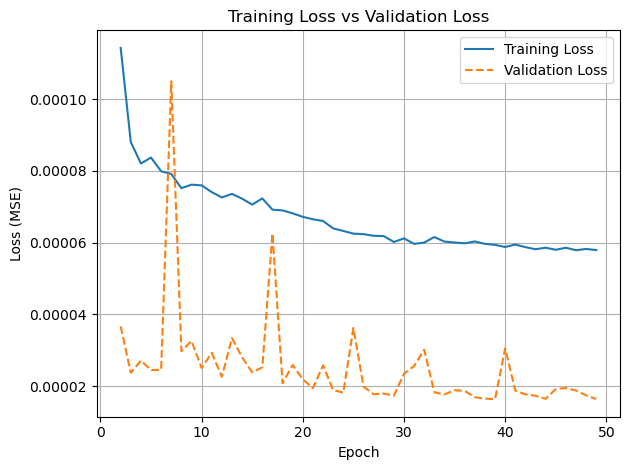

In [30]:
if TRAIN_MODEL:
    # Plot training loss
    # Exclude the first epoch (x=0) by slicing the data, as its a high value that obscures the plot
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs[1:], history.history['loss'][1:], label='Training Loss', linewidth=1.5)
    plt.plot(epochs[1:], history.history['val_loss'][1:], label='Validation Loss', linewidth=1.5, linestyle='--')
    
    #plt.plot(history.history['loss'], label='Training Loss')
    #plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # If training loss decreases but validation loss increases, this might indicate overfitting.
    # If both losses are high and close, this might indicate and inadequate model (more features?)
    # Best result is when both fall over epochs and flatten out, indicating a well trained model

### Predictions using  the LSTM model

In [32]:
# predict the values
y_pred = model.predict(X_test)

# inverse transform the predictions and actual test values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


### A test plot

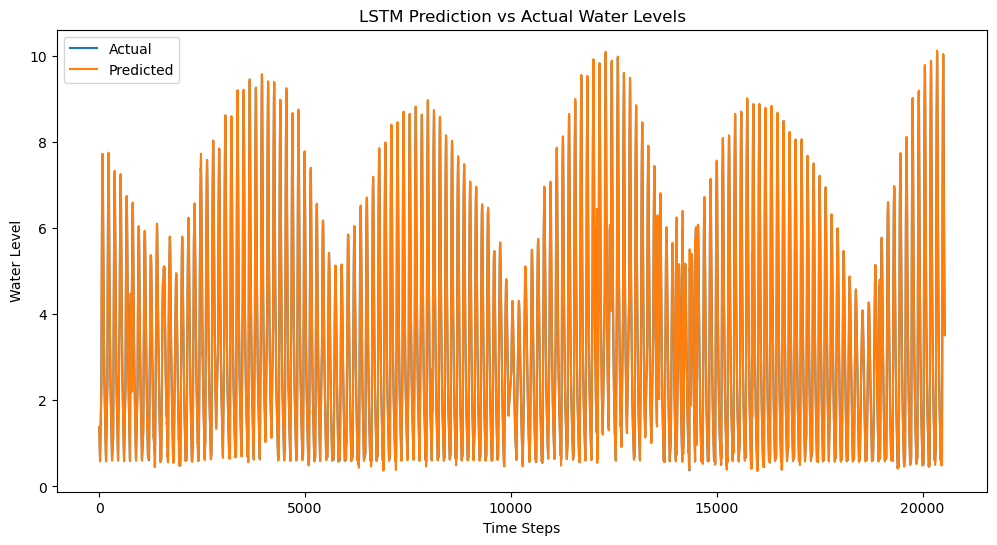

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.title('LSTM Prediction vs Actual Water Levels')
plt.xlabel('Time Steps')
plt.ylabel('Water Level')
plt.show()

### Forecasting future values

In [36]:
future_steps = 48 * 6 * days_to_forecast  # 48 steps represents just 4 hours of 5 minute data, *6 for a day

print(f'creating {future_steps} future predictions')

timesteps = X.shape[1]

# begin at the end
last_data = data_scaled[-timesteps:].reshape(1, timesteps, 1)

future_predictions = []

for _ in range(future_steps):
    prediction = model.predict(last_data, verbose=0)
    future_predictions.append(prediction[0, 0])
    last_data = np.append(last_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Inverse transform the future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
#print (future_predictions)

# Plot the future predictions
#plt.figure(figsize=(10, 6))
#plt.plot(df.index[-len(y_test_rescaled):], y_test_rescaled, color='blue', label='Actual values')
#plt.plot(pd.date_range(df.index[-1], periods=future_steps + 1, freq='5min')[1:], future_predictions, color='green', label='Future Predictions')
#plt.title('Future Value Prediction')
#plt.legend()
#plt.show()

creating 2016 future predictions


### Revisiting the interactive plot

In [38]:
df = pd.read_csv('EA_limited_dataset.csv')
df['r_datetime'] = pd.to_datetime(df['r_datetime'])
df = df.sort_values('r_datetime')
df['value_smooth'] = df['value'].rolling(window=24, center=True).mean()


dtm=datetime.today().strftime('%Y%m%d_%H%M%S')

createTimeplot  (df, 
                 show_predicted     = True,
                 future_steps       = future_steps,
                 future_predictions = future_predictions,
                 publishPlot        = True, 
                 plotName           =f'SharpnessWaterLevelPlot_{dtm}.html'
                )